In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
plt.style.use("Solarize_Light2")

In [10]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

sc = MinMaxScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

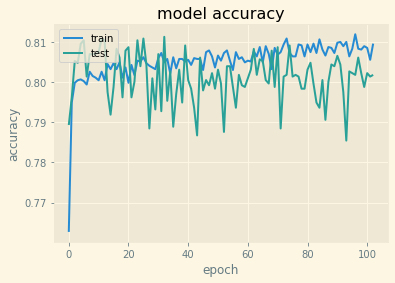

In [11]:
# Model 1

nn_model = Sequential()
nn_model.add(Dense(16,kernel_regularizer=tf.keras.regularizers.l2(0.01), input_dim=46, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(X_train.shape[0]/32)*50,
      decay_rate=1,
      staircase=False)
#This time decay means for every 50 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]

nn_model.compile(loss = "binary_crossentropy",
                  optimizer = get_optimizer(),
                  metrics=['accuracy'])


history = nn_model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=150, batch_size=32,   callbacks=get_callbacks(),verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<AxesSubplot:>

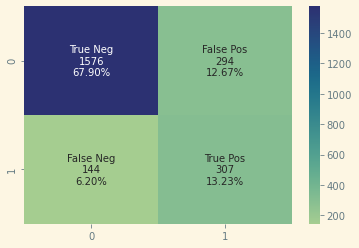

In [12]:
yprednn=nn_model.predict(X_test_sc)
yprednn=yprednn.round()

cf_matrix = metrics.confusion_matrix(yprednn, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [13]:
print(metrics.classification_report(yprednn, y_test))



              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      1870
         1.0       0.51      0.68      0.58       451

    accuracy                           0.81      2321
   macro avg       0.71      0.76      0.73      2321
weighted avg       0.84      0.81      0.82      2321



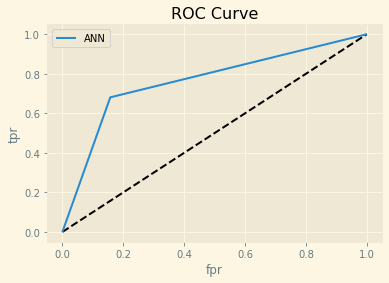

In [14]:
fpr, tpr, threshold = metrics.roc_curve(yprednn, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();


